# Fitting HSC data in multiband mode using MultiProFit

In [1]:
# Import required packages
from astropy.io.ascii import Csv
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.table as apTab
import astropy.visualization as apVis
from astropy.wcs import WCS
from dataclasses import dataclass
import gauss2d as g2
import gauss2d.fit as g2f
import matplotlib as mpl
import matplotlib.pyplot as plt
from multiprofit.componentconfig import SersicConfig, SersicIndexConfig
from multiprofit.fit_psf import CatalogExposurePsfABC, CatalogPsfFitterConfig, CatalogPsfFitter
from multiprofit.fit_source import CatalogExposureSourcesABC, CatalogSourceFitterABC, CatalogSourceFitterConfig
import numpy as np
from typing import Any, Iterable, Mapping

In [2]:
# Define settings
band_ref = 'i'
bands = {'i': 0.87108833, 'r': 0.97288654, 'g': 1.44564678}
band_multi = ''.join(bands)

# This is in the WCS, but may as well keep full precision
scale_pixel_hsc = 0.168

# Common to all FITS
hdu_img, hdu_mask, hdu_var = 1, 2, 3

# Masks
bad_masks = (
    'BAD', 'SAT', 'INTRP', 'CR', 'EDGE', 'CLIPPED', 'NO_DATA', 'CROSSTALK',
    'NO_DATA', 'UNMASKEDNAN', 'SUSPECT', 'REJECTED', 'SENSOR_EDGE',
)
maskbits = tuple(f'MP_{b}' for b in bad_masks)

# A pre-defined bitmask to exclude regions with low SN
read_mask_highsn = True
write_mask_highsn = False

# matplotlib settings
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.dpi'] = 120

In [3]:
# Define source to fit
id_gama, z = 79635, 0.0403
"""
Acquired from https://hsc-release.mtk.nao.ac.jp/datasearch/catalog_jobs with query:

SELECT object_id, ra, dec,
    g_cmodel_mag, g_cmodel_magerr, r_cmodel_mag, r_cmodel_magerr, i_cmodel_mag, i_cmodel_magerr,
    g_psfflux_mag, g_psfflux_magerr, r_psfflux_mag, r_psfflux_magerr, i_psfflux_mag, i_psfflux_magerr,
    g_kronflux_mag, g_kronflux_magerr, r_kronflux_mag, r_kronflux_magerr, i_kronflux_mag, i_kronflux_magerr,
    g_sdssshape_shape11, g_sdssshape_shape11err, g_sdssshape_shape22, g_sdssshape_shape22err,
    g_sdssshape_shape12, g_sdssshape_shape12err,
    r_sdssshape_shape11, r_sdssshape_shape11err, r_sdssshape_shape22, r_sdssshape_shape22err,
    r_sdssshape_shape12, r_sdssshape_shape12err,
    i_sdssshape_shape11, i_sdssshape_shape11err, i_sdssshape_shape22, i_sdssshape_shape22err,
    i_sdssshape_shape12, i_sdssshape_shape12err
FROM pdr3_wide.forced
LEFT JOIN pdr3_wide.forced2 USING (object_id)
WHERE isprimary AND conesearch(coord, 222.51551376, 0.09749601, 35.64)
AND (r_kronflux_mag < 26 OR i_kronflux_mag < 26) AND NOT i_kronflux_flag AND NOT r_kronflux_flag;
"""
cat = Csv()
cat.header.splitter.escapechar = '#'
cat = cat.read('fithsc_src.csv')

prefix = '222.51551376,0.09749601_'
prefix_img = f'{prefix}300x300_'

# Read data, acquired with:
# https://github.com/taranu/astro_imaging/blob/4d5a8e095e6a3944f1fbc19318b1dbc22b22d9ca/examples/HSC.ipynb
# (with get_mask=True, get_variance=True,)
images, psfs = {}, {}
for band in bands:
    images[band] = fits.open(f'{prefix_img}{band}.fits')
    psfs[band] = fits.open(f'{prefix}{band}_psf.fits')

wcs = WCS(images[band_ref][hdu_img])
cat['x'], cat['y'] = wcs.world_to_pixel(SkyCoord(cat['ra'], cat['dec'], unit='deg'))

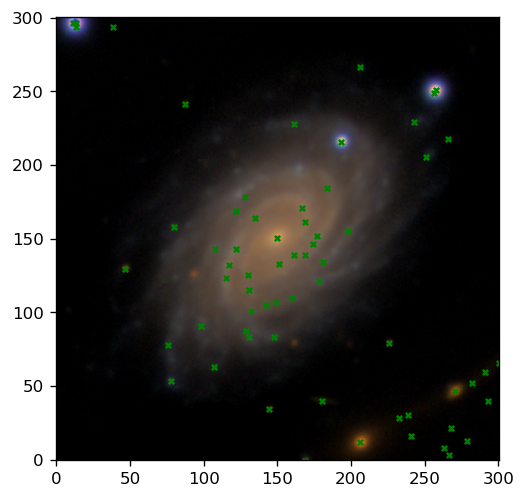

In [4]:
# Plot image
img_rgb = apVis.make_lupton_rgb(*[img[1].data*bands[band] for band, img in images.items()])
plt.scatter(cat['x'], cat['y'], s=10, c='g', marker='x')
plt.imshow(img_rgb)
plt.show()

Masking src=(42305088563206484 at 166.9999999851325, 170.99999998963358) dist=26.315394716483905, mag=22.460257, radius_mask=5
Masking src=(42305088563184638 at 106.61742095824866, 303.1694109023938) dist=158.85096716305983, mag=22.821213, radius_mask=3.9333352610107117
Masking src=(42305088563205967 at 335.3193409097212, 75.32735034309553) dist=199.52221939108293, mag=20.818096, radius_mask=8.80416600265281
Masking src=(42305088563206817 at 182.09254380488983, 326.2378342143129) dist=178.55496408221535, mag=20.32409, radius_mask=3.9415628267232785
Masking src=(42305088563184202 at 46.97410434226276, 129.6238100465398) dist=105.6097835368942, mag=22.441023, radius_mask=4.399387068213448
Masking src=(42305088563205970 at 341.99999998489966, 69.99999999048123) dist=207.73179822971036, mag=20.863632, radius_mask=9.09063217020512
Masking src=(42305088563195023 at 205.88452647856047, 266.14375354093863) dist=128.2221646451647, mag=22.060493, radius_mask=5
Masking src=(42305088563184398 at 2

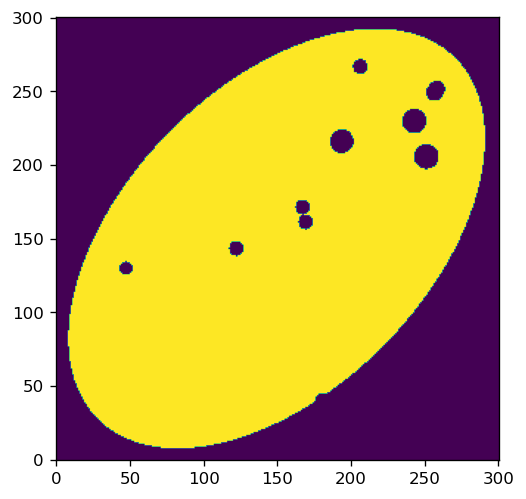

In [5]:
# Generate a rough mask around other sources
bright = (cat['i_cmodel_mag'] < 23) | (cat['i_psfflux_mag'] < 23)

img_ref = images[band_ref][hdu_img].data

mask_inverse = np.ones(img_ref.shape, dtype=bool)
y_cen, x_cen = (x/2. for x in img_ref.shape)
y, x = np.indices(img_ref.shape)

idx_src_main, row_main = None, None

sizes_override = {
    42305088563206480: 8.,
}

for src in cat[bright]:
    id_src, x_src, y_src = (src[col] for col in ['object_id', 'x', 'y'])
    dist = np.hypot(x_src - x_cen, y_src - y_cen)
    if dist > 20:
        dists = np.hypot(y - y_src, x - x_src)
        mag = np.nanmin([src['i_cmodel_mag'], src['r_cmodel_mag'], src['i_psfflux_mag'], src['r_psfflux_mag']])
        if (radius_mask := sizes_override.get(id_src)) is None:
            radius_mask = 2*np.sqrt(
                src[f'{band_ref}_sdssshape_shape11'] + src[f'{band_ref}_sdssshape_shape22']
            )/scale_pixel_hsc
            if (radius_mask > 10) and (mag > 21):
                radius_mask = 5
        mask_inverse[dists < radius_mask] = 0
        print(f'Masking src=({id_src} at {x_src}, {y_src}) dist={dist}'
              f', mag={mag}, radius_mask={radius_mask}')
    elif dist < 2:
        idx_src_main = id_src
        row_main = src
        print(f"{idx_src_main=} {dict(src)=}")

tab_row_main = apTab.Table(row_main)

if read_mask_highsn:
    mask_highsn = np.load(f'{prefix_img}mask_inv_highsn.npz')['mask_inv']
    mask_inverse *= mask_highsn

plt.imshow(mask_inverse)

In [6]:
# Fit PSF
@dataclass(frozen=True)
class CatalogExposurePsf(CatalogExposurePsfABC):
    catalog: apTab.Table
    img: np.ndarray

    def get_catalog(self) -> Iterable:
        return self.catalog

    def get_psf_image(self, source: apTab.Row | Mapping[str, Any]) -> np.array:
        return self.img

config_psf = CatalogPsfFitterConfig(column_id='object_id')
fitter_psf = CatalogPsfFitter()
catalog_psf = apTab.Table({'object_id': [tab_row_main['object_id']]})
results_psf = {}

for band, psf_file in psfs.items():
    catexp = CatalogExposurePsf(catalog=catalog_psf, img=psf_file[0].data)
    result = fitter_psf.fit(config=config_psf, catexp=catexp)
    results_psf[band] = result
    print(dict(result[0]))

{'object_id': 42305088563206481, 'mpf_psf_n_iter': 12, 'mpf_psf_time_eval': 0.004562398000000023, 'mpf_psf_time_fit': 0.010796135000000096, 'mpf_psf_time_full': 0.012839297999999832, 'mpf_psf_chisq_red': 0.9843337101113584, 'mpf_psf_unknown_flag': False, 'mpf_psf_cen_x': 21.505989945525492, 'mpf_psf_cen_y': 21.53047872307889, 'mpf_psf_comp1_sigma_x': 1.3732347402412084, 'mpf_psf_comp1_sigma_y': 1.3966415454285606, 'mpf_psf_comp1_rho': -0.02176528025252289, 'mpf_psf_comp1_fluxfrac': 0.7537097845117916, 'mpf_psf_comp2_sigma_x': 3.6335002563728, 'mpf_psf_comp2_sigma_y': 3.683080953952445, 'mpf_psf_comp2_rho': 2.5805498043762753e-05}
{'object_id': 42305088563206481, 'mpf_psf_n_iter': 12, 'mpf_psf_time_eval': 0.004274488000000964, 'mpf_psf_time_fit': 0.009479349000000248, 'mpf_psf_time_full': 0.010550246999999846, 'mpf_psf_chisq_red': 1.0538549949857767, 'mpf_psf_unknown_flag': False, 'mpf_psf_cen_x': 21.490912844263267, 'mpf_psf_cen_y': 20.52380408869913, 'mpf_psf_comp1_sigma_x': 1.4240980

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [7]:
# Set fit configs
config_source = CatalogSourceFitterConfig(
    column_id = 'object_id',
    n_pointsources=1,
    sersics={
        'disk': SersicConfig(
            sersicindex=SersicIndexConfig(value_initial=1., fixed=True),
            prior_size_stddev=0.3,
            prior_axrat_stddev=0.2,
        ),
        'bulge': SersicConfig(
            sersicindex=SersicIndexConfig(value_initial=4., fixed=True),
            prior_size_stddev=0.3,
            prior_axrat_stddev=0.2,
        ),
    }
)

In [8]:
# Setup exposure with band-specific image, mask and variance
@dataclass(frozen=True)
class CatalogExposureSources(CatalogExposureSourcesABC):
    config_psf: CatalogPsfFitterConfig
    observation: g2f.Observation
    table_psf_fits: apTab.Table

    @property
    def channel(self) -> g2f.Channel:
        return self.observation.channel

    def get_catalog(self) -> Iterable:
        return self.table_psf_fits
    
    def get_psfmodel(self, params: Mapping[str, Any]) -> g2f.PsfModel:
        return self.config_psf.rebuild_psfmodel(params)

    def get_source_observation(self, source: Mapping[str, Any]) -> g2f.Observation:
        return self.observation


@dataclass(kw_only=True)
class CatalogSourceFitter(CatalogSourceFitterABC):
    band: str
    scale_pixel: float
    wcs_ref: WCS
    
    def initialize_model(
        self,
        model: g2f.Model,
        source: Mapping[str, Any],
        limits_x: g2f.LimitsD = None,
        limits_y: g2f.LimitsD = None,
    ) -> None:
        x, y = source['x'], source['y']
        scale_sq = self.scale_pixel**(-2)
        ellipse = g2.Ellipse(g2.Covariance(
            sigma_x_sq=source[f'{band}_sdssshape_shape11']*scale_sq,
            sigma_y_sq=source[f'{band}_sdssshape_shape22']*scale_sq,
            cov_xy=source[f'{band}_sdssshape_shape12']*scale_sq,
        ))
        values_init = {
            g2f.CentroidXParameterD: x,
            g2f.CentroidYParameterD: y,
            g2f.ReffXParameterD: ellipse.sigma_x,
            g2f.ReffYParameterD: ellipse.sigma_y,
            # There is a sign convention difference
            g2f.RhoParameterD: -ellipse.rho,
        }
        size_major = g2.EllipseMajor(ellipse).r_major
        # An R_eff larger than the box size is problematic
        # Also should stop unreasonable size proposals; log10 transform isn't enough
        # TODO: Try logit for r_eff?
        limits_init = {
            g2f.IntegralParameterD: g2f.LimitsD(1e-6, 1e10),
            g2f.ReffXParameterD: g2f.LimitsD(1e-5, x),
            g2f.ReffYParameterD: g2f.LimitsD(1e-5, y),
        }
        for component in model.sources[0].components:
            params_free = component.parameters(paramfilter=g2f.ParamFilter(fixed=False))
            for param in params_free:
                type_param = type(param)
                if (value := values_init.get(type_param)) is not None:
                    param.value = value
                if (limits := limits_init.get(type_param)) is not None:
                    param.limits = limits
        for prior in model.priors:
            if isinstance(prior, g2f.ShapePrior):
                prior.prior_size.mean_parameter.value = g2.EllipseMajor(ellipse).r_major


In [9]:
# Set up Fitter, Observations and CatalogExposureSources
fitter = CatalogSourceFitter(band=band, scale_pixel=scale_pixel_hsc, wcs_ref=wcs)

observations = {}
catexps = {}

for band in bands:
    data = images[band]
    # There are better ways to use bitmasks, but this will do
    header = data[hdu_mask].header
    bitmask = data[hdu_mask].data
    mask = np.zeros_like(bitmask, dtype='bool')
    for bit in maskbits:
        mask |= ((bitmask & 2**header[bit]) != 0)

    mask = (mask == 0) & mask_inverse
    sigma_inv = 1.0/np.sqrt(data[hdu_var].data)
    sigma_inv[mask != 1] = 0

    observation = g2f.Observation(
        image=g2.ImageD(data[hdu_img].data),
        sigma_inv=g2.ImageD(sigma_inv),
        mask_inv=g2.ImageB(mask),
        channel=g2f.Channel.get(band),
    )
    observations[band] = observation
    catexps[band] = CatalogExposureSources(
        config_psf=config_psf,
        observation=observation,
        table_psf_fits=results_psf[band],
    )

In [10]:
# Now do the multi-band fit
result_multi = fitter.fit(
    catalog_multi=tab_row_main,
    catexps=list(catexps.values()),
    config=config_source,
)
print(dict(result_multi[0]))

{'object_id': 42305088563206481, 'mpf_n_iter': 16, 'mpf_time_eval': 7.180501138999998, 'mpf_time_fit': 7.451674843000001, 'mpf_time_full': 12.137253076, 'mpf_chisq_red': 57.25406127939979, 'mpf_unknown_flag': False, 'mpf_cen_x': 149.62570155077174, 'mpf_cen_y': 150.16740492530698, 'mpf_ps1_i_flux': 452.74494849738585, 'mpf_ps1_r_flux': 231.33607397030346, 'mpf_ps1_g_flux': 0.001, 'mpf_disk_sigma_x': 24.344893902561672, 'mpf_disk_sigma_y': 24.517271146420846, 'mpf_disk_rho': 0.47755098921638794, 'mpf_disk_i_flux': 60487.180569124976, 'mpf_disk_r_flux': 44670.9658886683, 'mpf_disk_g_flux': 24403.075867105836, 'mpf_bulge_sigma_x': 24.344893902561672, 'mpf_bulge_sigma_y': 24.517271146420846, 'mpf_bulge_rho': 0.47755098921638794, 'mpf_bulge_i_flux': 0.001, 'mpf_bulge_r_flux': 0.001, 'mpf_bulge_g_flux': 0.001, 'mpf_cen_ra': nan, 'mpf_cen_dec': nan, 'mpf_cen_x_err': 0.002027940553028402, 'mpf_cen_y_err': 0.0019401664168743333, 'mpf_ps1_i_flux_err': 0.6564683133669319, 'mpf_ps1_r_flux_err': 0.

/sdf/home/d/dtaranu/.local/lib/python3.11/site-packages/multiprofit-0.1-py3.11.egg/multiprofit/fit_source.py:399: RuntimeWarning: invalid value encountered in sqrt


In [11]:
# Fit in each band separately
results = {}
for band, observation in bands.items():
    result = fitter.fit(
        catalog_multi=tab_row_main,
        catexps=[catexps[band]],
        config=config_source,
    )
    results[band] = result
    print(dict(result[0]))

{'object_id': 42305088563206481, 'mpf_n_iter': 34, 'mpf_time_eval': 5.048680092999998, 'mpf_time_fit': 5.462639404000001, 'mpf_time_full': 6.600412048000001, 'mpf_chisq_red': 27.304427926705717, 'mpf_unknown_flag': False, 'mpf_cen_x': 150.269412989804, 'mpf_cen_y': 150.90857636044342, 'mpf_ps1_i_flux': 1.0092031267249566e-06, 'mpf_disk_sigma_x': 33.19854971312203, 'mpf_disk_sigma_y': 33.65758400380013, 'mpf_disk_rho': 0.448314311457895, 'mpf_disk_i_flux': 80299.37375848538, 'mpf_bulge_sigma_x': 2.0172200208285527, 'mpf_bulge_sigma_y': 0.9763449654633357, 'mpf_bulge_rho': 0.3483602947231973, 'mpf_bulge_i_flux': 1355.952487928108, 'mpf_cen_ra': nan, 'mpf_cen_dec': nan, 'mpf_cen_x_err': 0.0022766305626223397, 'mpf_cen_y_err': 0.0020792911761625316, 'mpf_ps1_i_flux_err': nan, 'mpf_disk_sigma_x_err': 0.006584048578012262, 'mpf_disk_sigma_y_err': 0.007241082530255507, 'mpf_disk_rho_err': 0.00019576326388653096, 'mpf_disk_i_flux_err': 13.897782271790687, 'mpf_bulge_sigma_x_err': 0.00974172602

In [12]:
# Make a model for the best-fit params
model, data, *_ = config_source.make_model_data(idx_source=0, catexps=list(catexps.values()))
params = list({p: None for p in model.parameters(paramfilter=g2f.ParamFilter(fixed=False))}.keys())
result_multi_row = dict(result_multi[0])
# This is the last column before fit params
idx_last = next(idx for idx, column in enumerate(result_multi_row.keys()) if column == 'mpf_unknown_flag')
# Set params to best fit values
for param, (column, value) in zip(params, list(result_multi_row.items())[idx_last+1:]):
    param.value = value
model.setup_evaluators(model.EvaluatorMode.loglike_image)
# Print the loglikelihoods, which are from the data and end with the (sum of all) priors
model.evaluate()

[-3458928.5469132625,
 -2289828.68118613,
 -2030826.2517429153,
 -1356.744594437025]

### Multiband Residuals

What's with the structure in the residuals? Most broadly, a point source + exponential disk + deVauc bulge model is totally inadequate for this galaxy for several possible reasons:

1. The disk isn't exactly exponential (n=1)
2. The disk has colour gradients not accounted for in this model*
3. If the galaxy even has a bulge, it's very weak and def. not a deVaucouleurs (n=4) profile; it may be an exponential "pseudobulge"

\*MultiProFit can do more general Gaussian mixture models (linear or non-linear), which may be explored in a future iteration of this notebook, but these are generally do not improve the accuracy of photometry for smaller/fainter galaxies.

Note that the two scalings of the residual plots (98%ile and +/- 20 sigma) end up looking very similar.


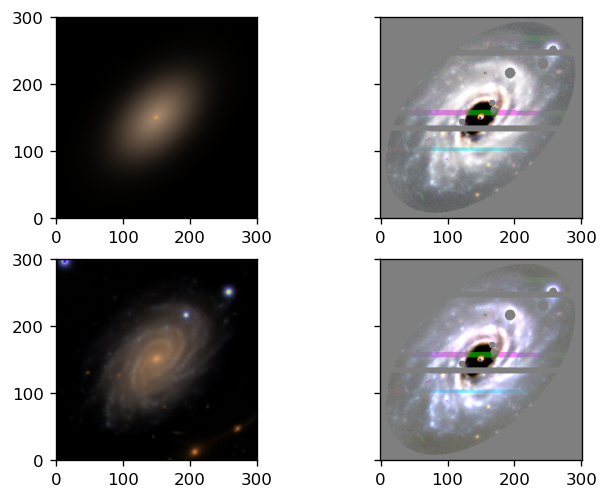

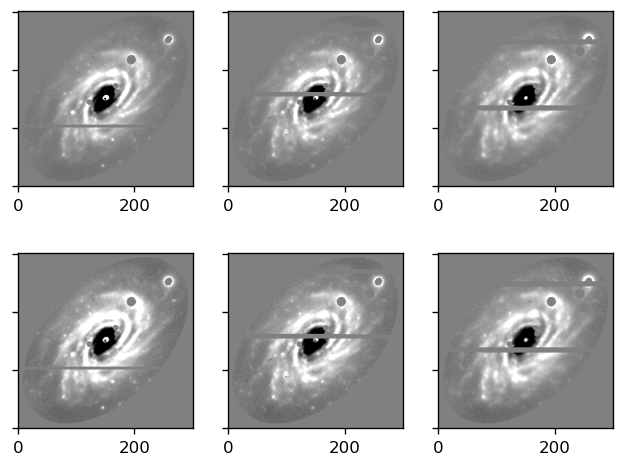

In [13]:
# Make some basic plots
img_model_rgb = apVis.make_lupton_rgb(
    *[output.data*weight for output, weight in zip(model.outputs, bands.values())]
)
fig_rgb, ax_rgb = plt.subplots(2, 2)
fig_bw, ax_bw = plt.subplots(2, len(bands))
ax_rgb[0][0].imshow(img_model_rgb)
ax_rgb[1][0].imshow(img_rgb)

residuals = {}
imgs_sigma_inv = {}
masks_inv = {}
if write_mask_highsn:
    # Create a mask of high-sn pixels (based on the model)
    mask_inv_highsn = np.ones(img_ref.shape, dtype='bool')

for idx, band in enumerate(bands):
    obs = catexps[band].observation
    mask_inv = obs.mask_inv.data
    masks_inv[band] = mask
    img_data = obs.image.data
    img_sigma_inv = obs.sigma_inv.data
    imgs_sigma_inv[band] = img_sigma_inv
    img_model = model.outputs[idx].data
    if write_mask_highsn:
        mask_highsn *= (img_model*np.nanmedian(img_sigma_inv)) > 0.2
    residual = (img_data - img_model)*mask_inv
    residuals[band] = residual
    value_max = np.percentile(np.abs(residual), 98)
    ax_bw[0][idx].imshow(residual, cmap='gray', vmin=-value_max, vmax=value_max)
    ax_bw[0][idx].tick_params(labelleft=False)
    ax_bw[1][idx].imshow(np.clip(residual*img_sigma_inv, -20, 20), cmap='gray')
    ax_bw[1][idx].tick_params(labelleft=False)

mask_inv_all = np.prod(list(masks_inv.values()), axis=0)

resid_max = np.percentile(
    np.abs(np.concatenate([(residual*mask_inv_all).flat for residual in residuals.values()])),
    98)

# This may or may not be equivalent to make_lupton_rgb
# I just can't figure out how to get that scaled so zero = 50% gray
stretch = 3
residual_rgb = np.stack([
    np.arcsinh(np.clip(residuals[band]*mask_inv_all*weight, -resid_max, resid_max)*stretch)
    for band, weight in bands.items()
], axis=-1)
residual_rgb /= 2*np.arcsinh(resid_max*stretch)
residual_rgb += 0.5

ax_rgb[0][1].imshow(residual_rgb)
ax_rgb[0][1].tick_params(labelleft=False)

residual_rgb = np.stack([
    (np.clip(residuals[band]*imgs_sigma_inv[band]*mask_inv_all*weight, -20, 20) + 20)/40
    for band, weight in bands.items()
], axis=-1)

ax_rgb[1][1].imshow(residual_rgb)
ax_rgb[1][1].tick_params(labelleft=False)

# Write the high SN bitmask to a compressed, bitpacked file
if write_mask_highsn:
    plt.figure()
    plt.imshow(mask_highsn, cmap='gray')
    plt.show()
    packed = np.packbits(mask_inv_highsn, bitorder='little')
    np.savez_compressed(f'{prefix_img}mask_inv_highsn.npz', mask_inv=mask_highsn)
    
# TODO: Plotting functions will be refactored from old MPF
# Missing features include colour residual images
# Also complete labels, etc.

### More exercises for the reader

These are of the sort that the author hasn't gotten around to yet because they're far from trivial. Try:

0. Use the WCS to compute ra, dec and errors thereof.
Hint: override CatalogSourceFitter.get_model_radec

1. Replace the real data with simulated data.
Make new observations using model.evaluate and add noise based on the variance maps.
Try fitting again and see how well results converge depending on the initialization scheme.

2. Fit every other source individually.
Try subtracting the best-fit galaxy model from above first.
Hint: get_source_observation should be redefined to return a smaller postage stamp around the nominal centroid.
Pass the full catalog (excluding the central galaxy) to catalog_multi.

3. Fit all sources simultaneously.
Redefine CatalogFitterConfig.make_model_data to make a model with multiple sources, using the catexp catalogs
initialize_model will no longer need to do anything
catalog_multi should still be a single row